In [1]:
import math
import torch
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from LightGCN import LightGCN
from RecommenderTrainer import *
from MovieDataProcessor import *
from sklearn.linear_model import LogisticRegression
from scipy.stats import spearmanr, pearsonr
import RecommenderCAV
from RecommenderCAV import *

In [40]:
# download dataset
# url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
# !wget -q {url} -O ml-1m.zip
# !unzip -q ml-1m.zip

# Set the directory for the dataset
data_path = "../hw1/ml-1m/ratings.dat"
movies_path = "../hw1/ml-1m/movies.dat"
users_path = "../hw1/ml-1m/users.dat"

# Load and preprocess data
processor = MovieDataProcessor(data_path, movies_path, users_path)
processor.load_data()

In [3]:
EMBEDDING_DIM = 64
NUM_LAYERS = 3
LEARNING_RATE = 0.01

# Define and train LightGCN model
model = LightGCN(
    num_users=processor.num_users,
    num_items=processor.num_items,
    embedding_dim=EMBEDDING_DIM,
    n_layers=NUM_LAYERS,
    user_feat_dim=processor.user_features.shape[1],
    item_feat_dim=processor.item_features.shape[1]
)

# trainer = RecommenderTrainer(model, 
#                              processor, 
#                              learning_rate=LEARNING_RATE)
# trainer.train(epochs=5)
# trainer.save_model("MovieLens_LightGCN.pth")

# Load the saved weights
model.load_state_dict(torch.load("MovieLens_LightGCN.pth"))
model.eval()

# Generate the final embeddings
model.get_final_embeddings(
    processor.adj_matrix, 
    processor.user_features, 
    processor.item_features
)


Epoch 1/5, Loss: -8699596.0000
Epoch 2/5, Loss: -13470253.0000
Epoch 3/5, Loss: -19318660.0000
Epoch 4/5, Loss: -26137010.0000
Epoch 5/5, Loss: -33759308.0000


In [4]:
print(processor.item_features.sum(axis=0))

tensor([  68.,  343.,  105.,  106.,  127.,  251., 1603.,  276.,   68.,  492.,
         114., 1200.,  143.,  211.,  283.,  503.,   44.,  471.])


In [41]:
# Find the CAV for Comedy
from sklearn.decomposition import PCA
import importlib
import RecommenderCAV
importlib.reload(RecommenderCAV)
from RecommenderCAV import *
import seaborn as sns

CAV = RecommenderCAV(processor=processor, model=model)
Comedy_cav = CAV.train_cav("Comedy")
Horror_cav = CAV.train_cav("Horror")
Thriller_cav = CAV.train_cav("Thriller")
Drama_cav = CAV.train_cav("Drama")

concept_names = ["Comedy", "Horror", "Thriller", "Drama"]
cav_vectors = np.array([Comedy_cav, Horror_cav, Thriller_cav, Drama_cav])

pca = PCA(n_components=2)
cav_2d = pca.fit_transform(cav_vectors)



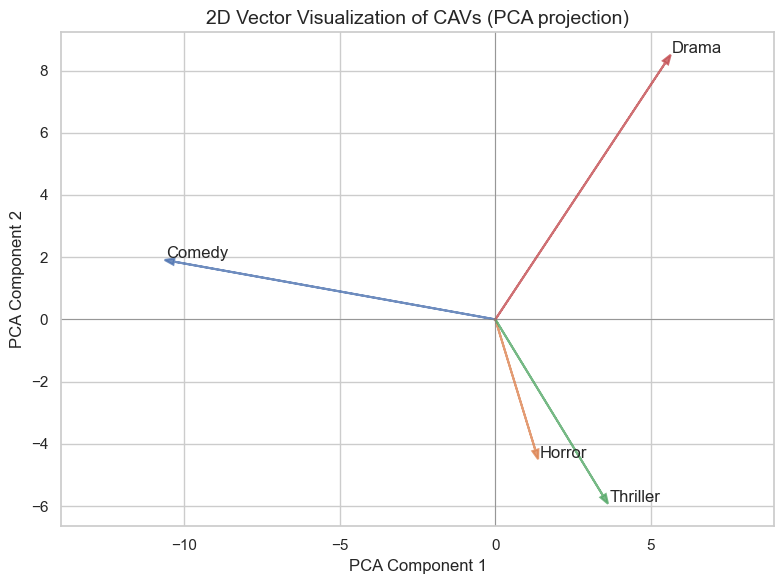

In [42]:
# Visualizing CAVS

plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Plot origin
origin = np.array([0, 0])

# Draw arrows from origin to each cav vector
for i, name in enumerate(concept_names):
    vec = cav_2d[i]
    plt.arrow(origin[0], origin[1], vec[0], vec[1],
              head_width=0.2, length_includes_head=True, color='C'+str(i), alpha=0.8, linewidth=1.5)
    plt.text(vec[0] + 0.05, vec[1] + 0.05, name, fontsize=12)

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)

plt.title("2D Vector Visualization of CAVs (PCA projection)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [7]:
user_proj_socres = model.final_user_embedding @ Comedy_cav
user_proj_socres.shape

torch.Size([6040])

In [8]:
# Compute user projections for comedy

user_proj_socres = model.final_user_embedding @ Comedy_cav

# Compute avergae ratings for comedy
genre_idx = processor.genre_mapping["Comedy"]
item_feature_matrix = processor.item_features.numpy()
is_concept = item_feature_matrix[:, genre_idx] == 1

user_ratings = {}
for u, i, r in processor.data[['user', 'item', 'rating']].values.tolist():
    if is_concept[i]:
        user_ratings.setdefault(u, []).append(r)
user_avg_comedy_ratings = {u: np.mean(r) for u, r in user_ratings.items()}
user_avg_comedy_ratings = np.array([user_avg_comedy_ratings.get(i, 0) for i in range(processor.num_users)])
user_avg_comedy_ratings.shape

(6040,)

In [9]:
# Compute correlation between user projections and average ratings
spearman_corr, _ = spearmanr(user_proj_socres, user_avg_comedy_ratings)
pearson_corr, _ = pearsonr(user_proj_socres, user_avg_comedy_ratings)
print(f"Spearman correlation: {spearman_corr}")
print(f"Pearson correlation: {pearson_corr}")    

Spearman correlation: -0.00883790832404443
Pearson correlation: -0.007376150607299388


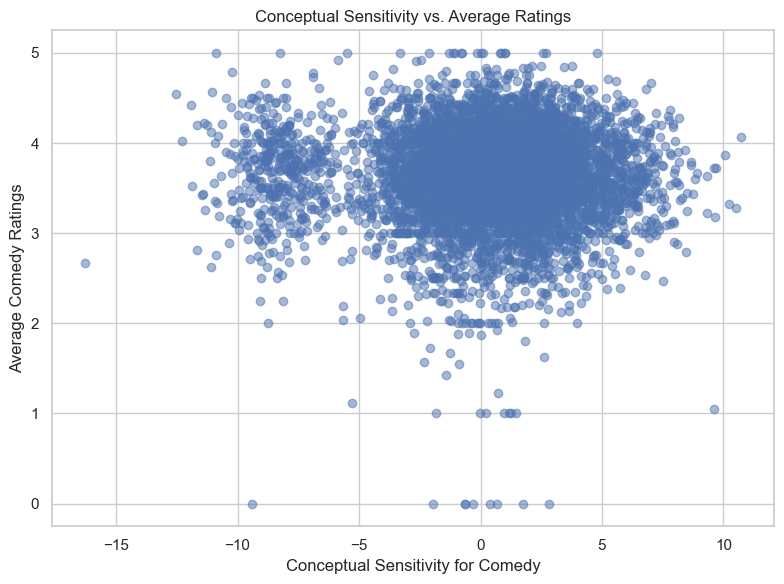

In [20]:
# Scatter plot of user projections and average ratings
plt.figure(figsize=(8, 6))
plt.scatter(user_avg_comedy_ratings, user_proj_socres, alpha=0.5)
plt.title("Conceptual Sensitivity vs. Average Ratings")
plt.xlabel("Average Comedy Ratings")
plt.ylabel("Conceptual Sensitivity for Comedy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
user_proj_socres_horror = model.final_user_embedding @ Horror_cav

genre_idx = processor.genre_mapping["Horror"]
item_feature_matrix = processor.item_features.numpy()
is_concept = item_feature_matrix[:, genre_idx] == 1

user_ratings = {}
for u, i, r in processor.data[['user', 'item', 'rating']].values.tolist():
    if is_concept[i]:
        user_ratings.setdefault(u, []).append(r)
user_avg_horror_ratings = {u: np.mean(r) for u, r in user_ratings.items()}
user_avg_horror_ratings = np.array([user_avg_horror_ratings.get(i, 0) for i in range(processor.num_users)])
user_avg_horror_ratings.shape

(6040,)

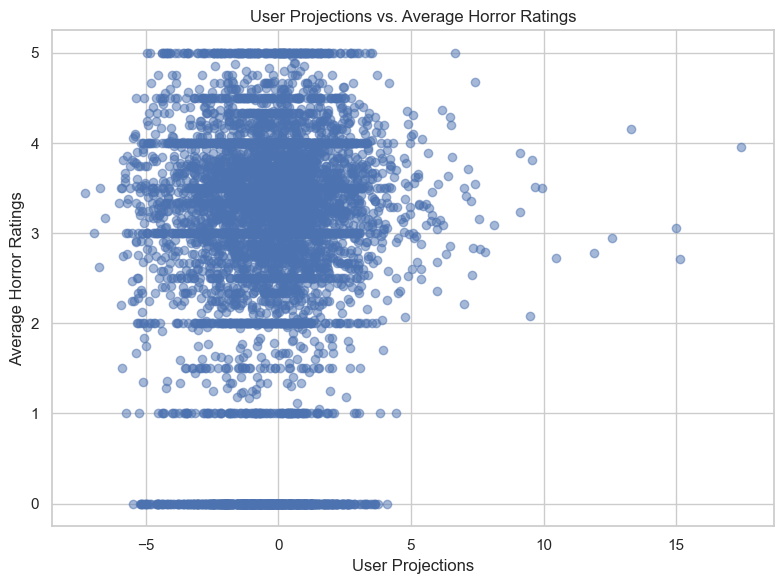

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(user_proj_socres_horror, user_avg_horror_ratings, alpha=0.5)
plt.title("User Projections vs. Average Horror Ratings")
plt.xlabel("User Projections")
plt.ylabel("Average Horror Ratings")
plt.grid(True)
plt.tight_layout()


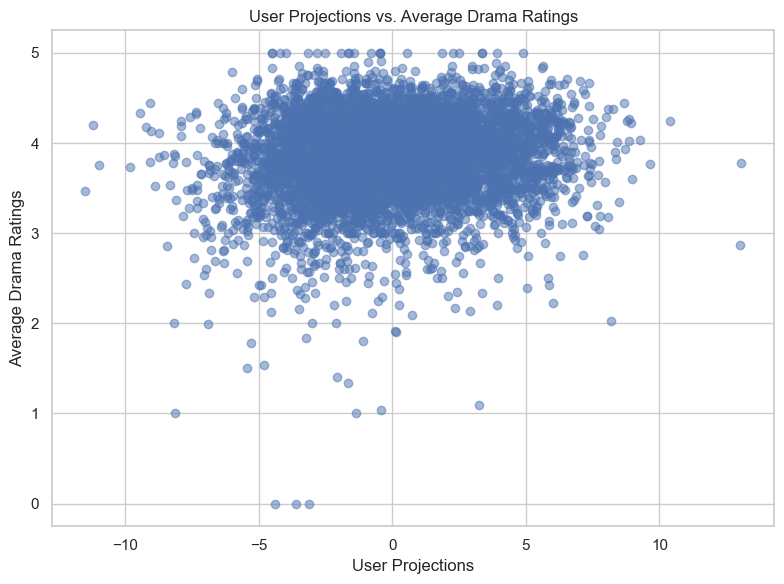

In [13]:
user_proj_scores_drama = model.final_user_embedding @ Drama_cav

genre_idx = processor.genre_mapping["Drama"]
item_feature_matrix = processor.item_features.numpy()
is_concept = item_feature_matrix[:, genre_idx] == 1

user_ratings = {}
for u, i, r in processor.data[['user', 'item', 'rating']].values.tolist():
    if is_concept[i]:
        user_ratings.setdefault(u, []).append(r)
user_avg_drama_ratings = {u: np.mean(r) for u, r in user_ratings.items()}
user_avg_drama_ratings = np.array([user_avg_drama_ratings.get(i, 0) for i in range(processor.num_users)])
user_avg_drama_ratings.shape

plt.figure(figsize=(8, 6))
plt.scatter(user_proj_scores_drama, user_avg_drama_ratings, alpha=0.5)
plt.title("User Projections vs. Average Drama Ratings")
plt.xlabel("User Projections")
plt.ylabel("Average Drama Ratings")
plt.grid(True)
plt.tight_layout()

In [15]:
processor.genre_mapping.keys()

dict_keys(['Fantasy', 'Horror', 'Animation', 'Mystery', 'Documentary', "Children's", 'Drama', 'Sci-Fi', 'Western', 'Thriller', 'Musical', 'Comedy', 'War', 'Crime', 'Adventure', 'Action', 'Film-Noir', 'Romance'])

In [21]:
concepts = processor.genre_mapping.keys()   
# Create a dictionary to store CAV vectors for each concept
cav_vectors = {}
correlation_results = {}

# Iterate through all concepts (movie genres)
for concept in concepts:
    # Train CAV for the current concept
    CAV = RecommenderCAV(processor, model)
    cav_vectors[concept] = CAV.train_cav(concept_genre=concept)
    
    # Get user projection scores for this concept
    user_proj_scores = model.final_user_embedding @ cav_vectors[concept]
    
    # Get users' average ratings for movies of this genre
    genre_idx = processor.genre_mapping[concept]
    item_feature_matrix = processor.item_features.numpy()
    is_concept = item_feature_matrix[:, genre_idx] == 1
    
    user_ratings = {}
    for u, i, r in processor.data[['user', 'item', 'rating']].values.tolist():
        if is_concept[i]:
            user_ratings.setdefault(u, []).append(r)
    
    user_avg_ratings = {u: np.mean(r) for u, r in user_ratings.items()}
    user_avg_ratings = np.array([user_avg_ratings.get(i, 0) for i in range(processor.num_users)])
    
    # Calculate correlation (Pearson correlation coefficient)
    # Filter out users with average rating of 0 (meaning they haven't rated movies of this genre)
    valid_indices = user_avg_ratings > 0
    if np.sum(valid_indices) > 10:  # Ensure there are enough data points for correlation calculation
        correlation, p_value = pearsonr(
            user_proj_scores[valid_indices], 
            user_avg_ratings[valid_indices]
        )
        correlation_results[concept] = {
            'correlation': correlation,
            'p_value': p_value,
            'num_users': np.sum(valid_indices)
        }
    else:
        correlation_results[concept] = {
            'correlation': np.nan,
            'p_value': np.nan,
            'num_users': np.sum(valid_indices)
        }

# Sort and display results by correlation strength
sorted_results = sorted(
    correlation_results.items(), 
    key=lambda x: abs(x[1]['correlation']) if not np.isnan(x[1]['correlation']) else 0,
    reverse=True
)

print("Concept-User Rating Correlation Ranking:")
for concept, result in sorted_results:
    if np.isnan(result['correlation']):
        print(f"{concept}: Insufficient data (Users: {result['num_users']})")
    else:
        print(f"{concept}: Correlation = {result['correlation']:.4f}, p-value = {result['p_value']:.4f}, Users = {result['num_users']}")


Concept-User Rating Correlation Ranking:
Drama: Correlation = 0.1140, p-value = 0.0000, Users = 6037
Fantasy: Correlation = 0.1023, p-value = 0.0000, Users = 4850
Romance: Correlation = 0.1022, p-value = 0.0000, Users = 5961
Adventure: Correlation = 0.0875, p-value = 0.0000, Users = 5894
War: Correlation = 0.0709, p-value = 0.0000, Users = 5769
Musical: Correlation = 0.0694, p-value = 0.0000, Users = 4754
Action: Correlation = 0.0682, p-value = 0.0000, Users = 6012
Documentary: Correlation = 0.0535, p-value = 0.0113, Users = 2243
Sci-Fi: Correlation = 0.0427, p-value = 0.0010, Users = 5911
Film-Noir: Correlation = 0.0349, p-value = 0.0244, Users = 4150
Horror: Correlation = 0.0349, p-value = 0.0112, Users = 5300
Animation: Correlation = 0.0267, p-value = 0.0645, Users = 4808
Mystery: Correlation = -0.0217, p-value = 0.1199, Users = 5133
Children's: Correlation = 0.0178, p-value = 0.1950, Users = 5283
Crime: Correlation = 0.0152, p-value = 0.2524, Users = 5662
Thriller: Correlation = -0

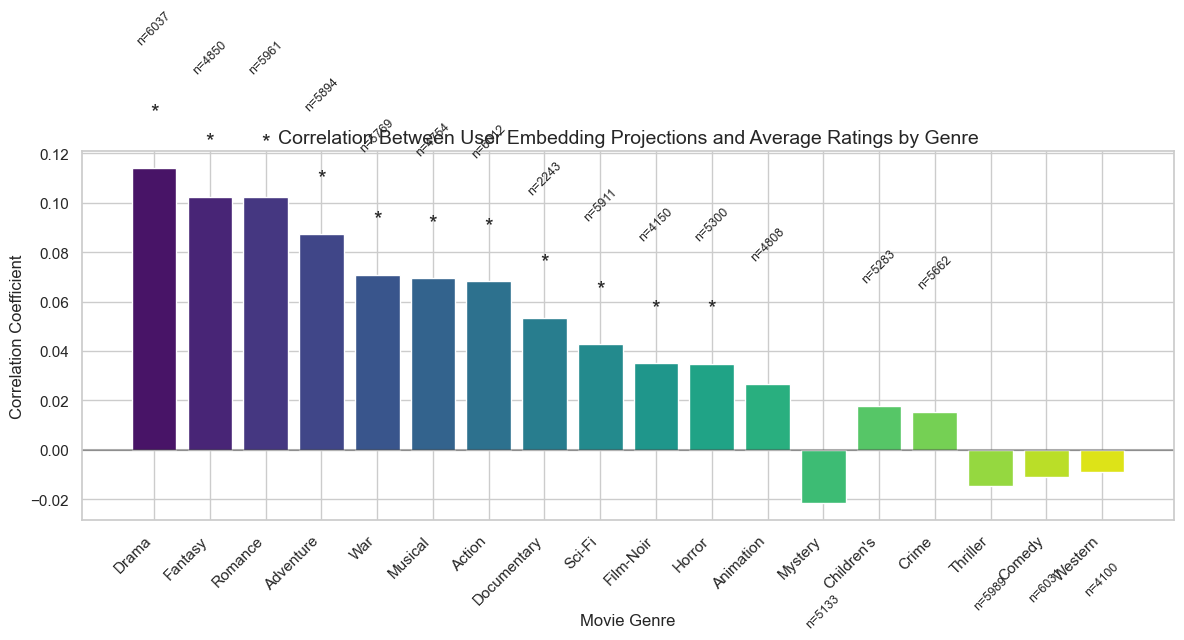

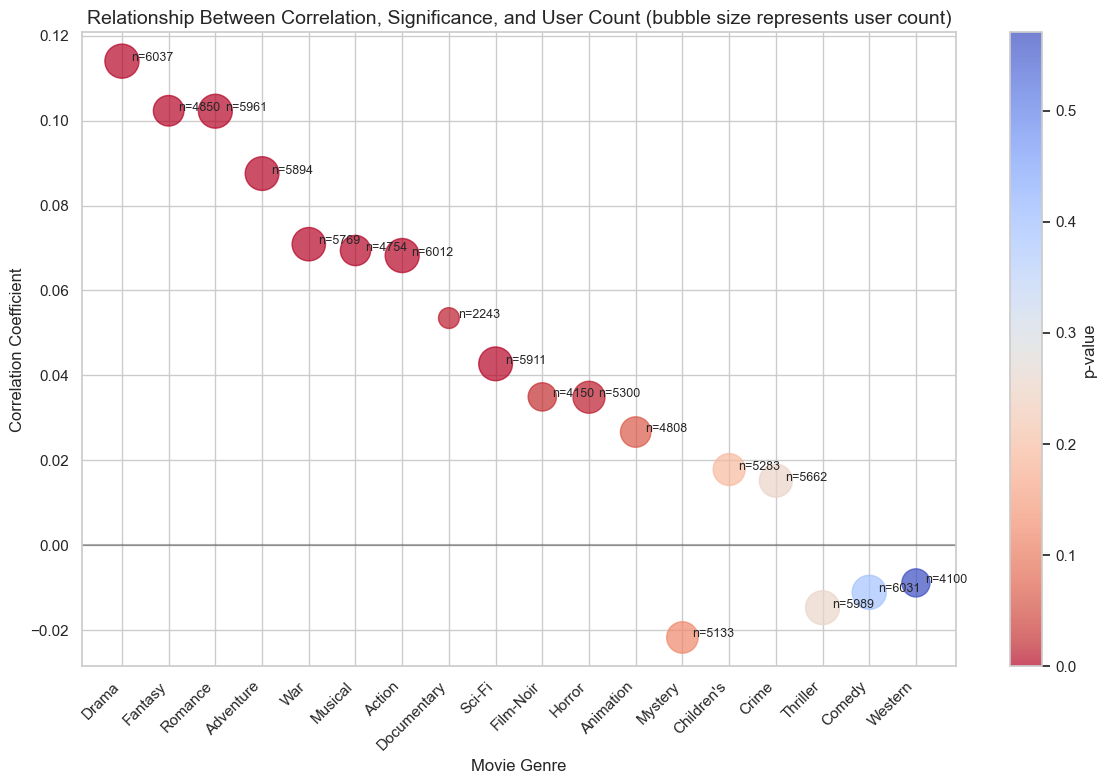

In [23]:
# Visualize correlation results
import matplotlib.pyplot as plt
import seaborn as sns

# Extract valid correlation data (filter out NaN values)
valid_concepts = []
correlations = []
p_values = []
user_counts = []

for concept, result in sorted_results:
    if not np.isnan(result['correlation']):
        valid_concepts.append(concept)
        correlations.append(result['correlation'])
        p_values.append(result['p_value'])
        user_counts.append(result['num_users'])

# Create correlation bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(valid_concepts, correlations, color=sns.color_palette("viridis", len(valid_concepts)))

# Add asterisk markers for statistically significant correlations (p < 0.05)
# and sample sizes above each bar
for i, (p, count) in enumerate(zip(p_values, user_counts)):
    # Add significance marker if applicable
    if p < 0.05:
        plt.text(i, correlations[i] + 0.02 * (1 if correlations[i] >= 0 else -1), 
                 '*', ha='center', fontsize=16)
    
    # Add sample size (n=X) above or below each bar
    y_pos = correlations[i] + 0.05 * (1 if correlations[i] >= 0 else -1)
    plt.text(i, y_pos, f'n={count}', ha='center', fontsize=9, rotation=45)

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Movie Genre', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.title('Correlation Between User Embedding Projections and Average Ratings by Genre', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create bubble chart showing correlation, p-value, and user count
plt.figure(figsize=(12, 8))
scatter = plt.scatter(range(len(valid_concepts)), correlations, 
                     s=[count/10 for count in user_counts], # Bubble size determined by user count
                     c=p_values, cmap='coolwarm_r', # Color determined by p-value (smaller = redder)
                     alpha=0.7)

# Add sample size labels next to each bubble
for i, count in enumerate(user_counts):
    plt.text(i + 0.2, correlations[i], f'n={count}', fontsize=9)

plt.colorbar(scatter, label='p-value')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xticks(range(len(valid_concepts)), valid_concepts, rotation=45, ha='right')
plt.xlabel('Movie Genre', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.title('Relationship Between Correlation, Significance, and User Count (bubble size represents user count)', fontsize=14)
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Average Drama Ratings')

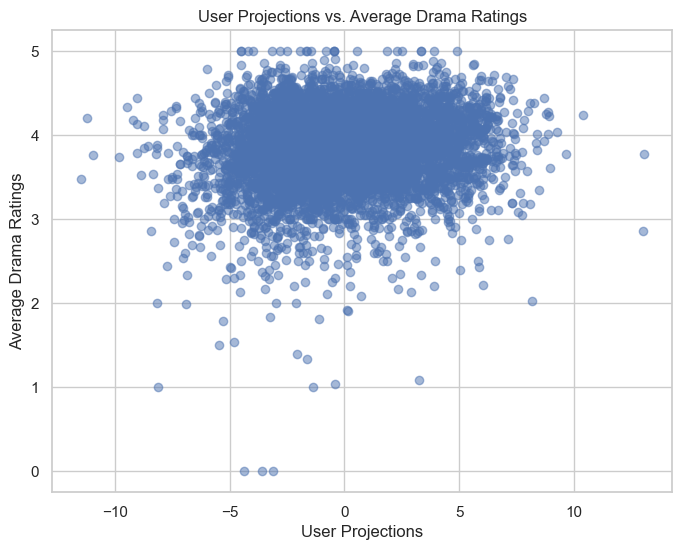

In [46]:
drame_proj_scores = model.final_user_embedding @ Drama_cav

plt.figure(figsize=(8, 6))
plt.scatter(drame_proj_scores, user_avg_drama_ratings, alpha=0.5)
plt.title("User Projections vs. Average Drama Ratings")
plt.xlabel("User Projections")
plt.ylabel("Average Drama Ratings")

In [50]:
processor.users.head()

,user,gender,age,K-12 student,academic/educator,artist,clerical/admin,college/grad student,customer service,doctor/health care,...,other or not specified,programmer,retired,sales/marketing,scientist,self-employed,technician/engineer,tradesman/craftsman,unemployed,writer
0,0,1,1,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,0,56,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,2,0,25,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,3,0,45,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,0,25,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


# Train LightGCN without item features and user features

In [24]:
# ... existing code ...

# Train a LightGCN model without using any user or item features
print("Training a LightGCN model without user or item features")

# 1. Create a LightGCN model with the same parameters
EMBEDDING_DIM = 64
NUM_LAYERS = 3
LEARNING_RATE = 0.01

# 2. Create zero feature embeddings
zero_user_features = torch.zeros_like(processor.user_features)
zero_item_features = torch.zeros_like(processor.item_features)

# 3. Define and train the model without feature influence
no_feature_model = LightGCN(
    num_users=processor.num_users,
    num_items=processor.num_items,
    embedding_dim=EMBEDDING_DIM,
    n_layers=NUM_LAYERS,
    user_feat_dim=processor.user_features.shape[1],
    item_feat_dim=processor.item_features.shape[1]
)

# Create a trainer with zero features
no_feature_processor = processor.copy()
no_feature_processor.user_features = zero_user_features
no_feature_processor.item_features = zero_item_features

no_feature_trainer = RecommenderTrainer(no_feature_model, 
                                        no_feature_processor, 
                                        learning_rate=LEARNING_RATE)

# Train the model without features
no_feature_trainer.train(epochs=5)

# Save the model
no_feature_trainer.save_model("MovieLens_LightGCN_No_Features.pth")

Training a LightGCN model without user or item features
Epoch 1/5, Loss: -34181392.0000
Epoch 2/5, Loss: -48190948.0000
Epoch 3/5, Loss: -63660556.0000
Epoch 4/5, Loss: -79855256.0000
Epoch 5/5, Loss: -96103584.0000


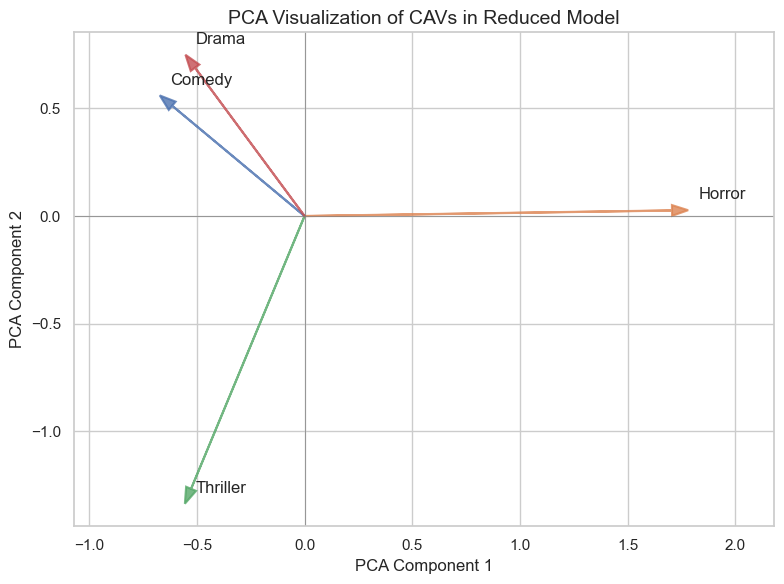

In [45]:
#PCA visualization of CAVs in the reduced model


exmaple_genres = ["Comedy", "Horror", "Thriller", "Drama"]

reduced_CAV = RecommenderCAV(processor, no_feature_model)

example_cavs = {}
for genre in exmaple_genres:
    example_cavs[genre] = reduced_CAV.train_cav(genre)

cav_vectors = np.array(list(example_cavs.values()))

pca = PCA(n_components=2)   
cav_2d = pca.fit_transform(cav_vectors)

plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

origin = np.array([0, 0])

for i, genre in enumerate(exmaple_genres):
    vec = cav_2d[i]
    plt.arrow(origin[0], origin[1], vec[0], vec[1], 
              head_width=0.05, length_includes_head=True, color='C'+str(i), alpha=0.8, linewidth=1.5)
    plt.text(vec[0] + 0.05, vec[1] + 0.05, genre, fontsize=12)

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)

plt.title("PCA Visualization of CAVs in Reduced Model", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

# It is hard to distinguish genre based only on interaction between users and items.


In [38]:
genre_indices = processor.genre_mapping
genre_column = genre_indices.get("Comedy", None)
labels = processor.item_features[:, genre_column].numpy().astype(int)



0